In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

#Import Necessary Library

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms

In [ ]:
from torchsummary import summary
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
import skimage as sk
import random
from sklearn.decomposition import  PCA

#Load CIFAR10

In [ ]:
# Loading and normalizing CIFAR10

transform = transforms.Compose(
      [#transforms.Pad(4),
      #transforms.RandomHorizontalFlip(),
      #transforms.RandomCrop(32),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(trainset)

50000

In [ ]:
#deleteme
type(trainset)

torchvision.datasets.cifar.CIFAR10

torch.Size([100, 3, 32, 32])


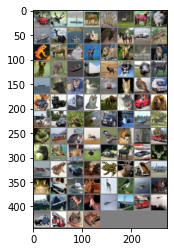

  car  deer  ship horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images[0]

tensor([[[-0.5294, -0.4118, -0.3412,  ..., -0.4980, -0.4588, -0.1451],
         [-0.6078, -0.6000, -0.5059,  ..., -0.4431, -0.5216, -0.3647],
         [-0.6941, -0.8118, -0.7725,  ..., -0.4902, -0.5373, -0.4510],
         ...,
         [ 0.2471,  0.2078,  0.1922,  ...,  0.0980,  0.0196, -0.0275],
         [ 0.2706,  0.2392,  0.2235,  ...,  0.0902,  0.0510,  0.0431],
         [ 0.2863,  0.2549,  0.2706,  ...,  0.0980,  0.0980,  0.0588]],

        [[-0.4275, -0.2941, -0.2392,  ..., -0.4118, -0.3647, -0.0588],
         [-0.5137, -0.4824, -0.3882,  ..., -0.2941, -0.3882, -0.2235],
         [-0.6000, -0.6941, -0.6549,  ..., -0.3098, -0.3804, -0.3176],
         ...,
         [ 0.1686,  0.1373,  0.1373,  ...,  0.0824,  0.0039, -0.0431],
         [ 0.1843,  0.1686,  0.1608,  ...,  0.0745,  0.0353,  0.0275],
         [ 0.2078,  0.1843,  0.2078,  ...,  0.0824,  0.0824,  0.0431]],

        [[-0.5922, -0.4353, -0.3412,  ..., -0.6471, -0.6157, -0.2941],
         [-0.6627, -0.6471, -0.5294,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


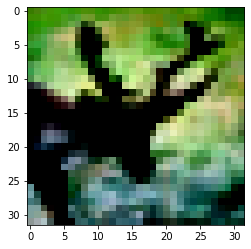

In [ ]:
#dataiter = iter(trainloader)
#images, labels = dataiter.next()
print(images.shape)
plt.imshow(np.transpose(images[1], (1, 2, 0)))
plt.show()

#Load Simple Model for CIFAR10

In [ ]:
dropout=0.10 
output_dim=10
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() 
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 2), # conv1
            nn.ReLU(),
            nn.Conv2d(32, 32, 2), # conv2
            nn.BatchNorm2d(32), # bn_32
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 2), # conv3
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), # conv4
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # conv5
            nn.ReLU(),
            nn.Conv2d(128, 128, 3), # conv6
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout))

        

        self.fc = nn.Linear(128, 500)
        self.fc2 = nn.Linear(500, 72)
        self.fc3 = nn.Linear(72, output_dim)
    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


# Mondel training and validation

In [ ]:
# a map for the class
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
convNet = CNN().to(device)
convNet

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

In [ ]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(convNet.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(convNet.parameters(), lr=0.01)
#optimizer = optim.Adam(convNet.parameters())

Function for Training the Model:

In [ ]:
from statistics import mean
def train_model (model, optimizer, EPOCHS, train_loader):
  train_loss_list = []
  loss = 0.0
  for i in range(EPOCHS):
    print("the %d th epoch..." %i)
    for k, data in enumerate(train_loader):
      images, labels = data
      if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
      optimizer.zero_grad()
      output_train = model(images)
      train_loss = criterion(output_train, labels)
      train_loss_list.append(train_loss)
      train_loss.backward()
      optimizer.step()
      loss += train_loss.item()
      if k%100 == 99:
          print(k+1, 'mini-batch of',i, '-th epoch','train loss :', loss/100)
          loss = 0.0
        
    train_loss_list.append(train_loss.item())
  return train_loss_list

In [ ]:
# Save our trained model
#PATH = './cifar_net.pth'
#torch.save(convNet.state_dict(), PATH)

In [ ]:
# load trained model
#model = torch.load('./cifar_net.pth')

Function for testing the Model:

In [ ]:
def test_model(model,data_loader, training=False):
  correct = 0.0
  total = 0.0
  # for plotting
  num_true = []
  num_pred = []
  letter_true = []
  letter_pred = []
  #
  with torch.no_grad():
      for data in data_loader:
          images, labels = data
          if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  if not training:
    print(print('Accuracy of the network on the  test images: {} '.format(correct / total)))
    return (100 * correct / total)
  else:
    print('Accuracy of the network on the  training images: {}'.format( correct / total))
    return (100 * correct / total)

In [ ]:
print('Accuracy of the network on the  test images: {} '.format(50/100))


Accuracy of the network on the  test images: 0.5 


Apply Trainning and Testing:

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [ ]:
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
#scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=0.8, total_iters=10)
def train_and_test(times, epoch):
  loss = []
  val_acc = []
  train_acc = []
  for time in range(times):
    print("Training for the", time+1, '-th times')
    loss.extend(train_model(convNet, optimizer, epoch, trainloader))
    if time == times-1:
      train_acc.append(test_model (convNet, trainloader, training=True))
      val_acc.append(test_model (convNet, testloader))
      break
      
    train_acc.append(test_model (convNet, trainloader, training=True))
    #val_acc.append(test_model (convNet, testloader))
  return loss, train_acc, val_acc
  '''
  num_times = np.array(range(1,times+1))
  num_epoch = np.array(range(1,times*epoch+1))
  plt.plot(num_epoch, loss)
  plt.title("training loss vs epochs")
  plt.show()

  plt.plot(num_times, train_acc, label="training")
  plt.plot(num_times, val_acc, label="validation")
  plt.title("accuracy vs training times")
  plt.legend()
  plt.show()
  '''

In [ ]:
def draw_graph(times, epoch, loss, train_acc, val_acc):
  num_times = np.array(range(1,times+1))
  num_epoch = np.array(range(1,times*epoch+1))
  plt.plot(num_epoch, loss)
  plt.title("training loss vs epochs")
  plt.xlabel('epoch')
  plt.ylabel('training loss')
  plt.show()

  plt.plot(num_times, train_acc, label="training")
  plt.plot(num_times, val_acc, label="validation")
  plt.title("accuracy vs training times")
  plt.xlabel('times')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

In [ ]:
loss, train_acc, val_acc = train_and_test(10, 3)

Training for the 1 -th times
the 0 th epoch...
100 mini-batch of 0 -th epoch train loss : 2.2543905460834504
200 mini-batch of 0 -th epoch train loss : 1.7438404476642608
300 mini-batch of 0 -th epoch train loss : 1.558675490617752
400 mini-batch of 0 -th epoch train loss : 1.4120349752902985
500 mini-batch of 0 -th epoch train loss : 1.3244819337129592
the 1 th epoch...
100 mini-batch of 1 -th epoch train loss : 1.214234978556633
200 mini-batch of 1 -th epoch train loss : 1.1750989270210266
300 mini-batch of 1 -th epoch train loss : 1.1534900671243669
400 mini-batch of 1 -th epoch train loss : 1.1221298956871033
500 mini-batch of 1 -th epoch train loss : 1.0748437887430191
the 2 th epoch...
100 mini-batch of 2 -th epoch train loss : 1.0271512746810914
200 mini-batch of 2 -th epoch train loss : 0.9987900632619858
300 mini-batch of 2 -th epoch train loss : 0.9723154044151306
400 mini-batch of 2 -th epoch train loss : 0.9372647851705551
500 mini-batch of 2 -th epoch train loss : 0.922734

ValueError: ignored

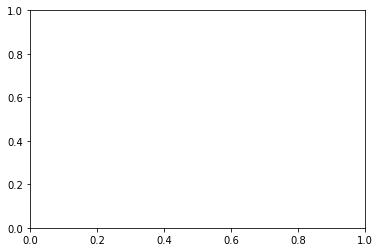

In [ ]:
draw_graph(10, 3, loss, train_acc, val_acc)

In [ ]:
'''
def draw_graph(loss, train_acc, val_acc):
  #num_times = np.array(range(1,times+1))
  #num_epoch = np.array(range(1,times*epoch+1))
  plt.plot(loss)
  #plt.plot(num_epoch, loss)
  plt.title("training loss vs epochs")
  plt.show()

  plt.plot(train_acc, label="training")
  plt.plot(val_acc, label="validation")

  #plt.plot(num_times, train_acc, label="training")
  #plt.plot(num_times, val_acc, label="validation")
  plt.title("accuracy vs training times")
  plt.show()
'''

In [ ]:
loss, train_acc, val_acc = train_and_test(1, 1)

In [ ]:
train_and_test(1, 1)

Training for the 1 -th times
the 0 th epoch...
100 mini-batch of 0 -th epoch train loss : 0.31080619417130945
200 mini-batch of 0 -th epoch train loss : 0.3305718846619129
300 mini-batch of 0 -th epoch train loss : 0.33856473967432976
400 mini-batch of 0 -th epoch train loss : 0.34351072415709494
500 mini-batch of 0 -th epoch train loss : 0.3327855543792248
Accuracy of the network on the  training images: 0.89548
Accuracy of the network on the  test images: 0.7766 
None


([tensor(0.2930, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.3441, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.3168, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.2799, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.4001, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.3496, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.3641, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.2809, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.3213, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.1472, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.1252, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.2727, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.4122, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.3452, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.3309, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(0.3307, device='cuda:0', grad_fn=<NllLossBackw

#Load embeded model for CIFAR10

RepVGG(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False, use_se=False)

In [ ]:
#se_block.py
dropout=0.10 
output_dim=10
import torch
import torch.nn as nn
import torch.nn.functional as F

#   https://openaccess.thecvf.com/content_cvpr_2018/html/Hu_Squeeze-and-Excitation_Networks_CVPR_2018_paper.html

class SEBlock(nn.Module):

    def __init__(self, input_channels, internal_neurons):
        super(SEBlock, self).__init__()
        self.down = nn.Conv2d(in_channels=input_channels, out_channels=internal_neurons, kernel_size=1, stride=1, bias=True)
        self.up = nn.Conv2d(in_channels=internal_neurons, out_channels=input_channels, kernel_size=1, stride=1, bias=True)
        self.input_channels = input_channels

    def forward(self, inputs):
        x = F.avg_pool2d(inputs, kernel_size=inputs.size(3))
        x = self.down(x)
        x = F.relu(x)
        x = self.up(x)
        x = torch.sigmoid(x)
        x = x.view(-1, self.input_channels, 1, 1)
        return inputs * x

In [ ]:
# model.py 
import torch.nn as nn
import numpy as np
import torch
import copy
#from se_block import SEBlock

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False, use_se=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if use_se:
            self.se = SEBlock(out_channels, internal_neurons=out_channels // 16)
        else:
            self.se = nn.Identity()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.se(self.rbr_reparam(inputs)))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.se(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out))


    #   Optional. This improves the accuracy and facilitates quantization.
    #   1.  Cancel the original weight decay on rbr_dense.conv.weight and rbr_1x1.conv.weight.
    #   2.  Use like this.
    #       loss = criterion(....)
    #       for every RepVGGBlock blk:
    #           loss += weight_decay_coefficient * 0.5 * blk.get_cust_L2()
    #       optimizer.zero_grad()
    #       loss.backward()
    def get_custom_L2(self):
        K3 = self.rbr_dense.conv.weight
        K1 = self.rbr_1x1.conv.weight
        t3 = (self.rbr_dense.bn.weight / ((self.rbr_dense.bn.running_var + self.rbr_dense.bn.eps).sqrt())).reshape(-1, 1, 1, 1).detach()
        t1 = (self.rbr_1x1.bn.weight / ((self.rbr_1x1.bn.running_var + self.rbr_1x1.bn.eps).sqrt())).reshape(-1, 1, 1, 1).detach()

        l2_loss_circle = (K3 ** 2).sum() - (K3[:, :, 1:2, 1:2] ** 2).sum()      # The L2 loss of the "circle" of weights in 3x3 kernel. Use regular L2 on them.
        eq_kernel = K3[:, :, 1:2, 1:2] * t3 + K1 * t1                           # The equivalent resultant central point of 3x3 kernel.
        l2_loss_eq_kernel = (eq_kernel ** 2 / (t3 ** 2 + t1 ** 2)).sum()        # Normalize for an L2 coefficient comparable to regular L2.
        return l2_loss_eq_kernel + l2_loss_circle



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def switch_to_deploy(self):
        if hasattr(self, 'rbr_reparam'):
            return
        kernel, bias = self.get_equivalent_kernel_bias()
        self.rbr_reparam = nn.Conv2d(in_channels=self.rbr_dense.conv.in_channels, out_channels=self.rbr_dense.conv.out_channels,
                                     kernel_size=self.rbr_dense.conv.kernel_size, stride=self.rbr_dense.conv.stride,
                                     padding=self.rbr_dense.conv.padding, dilation=self.rbr_dense.conv.dilation, groups=self.rbr_dense.conv.groups, bias=True)
        self.rbr_reparam.weight.data = kernel
        self.rbr_reparam.bias.data = bias
        for para in self.parameters():
            para.detach_()
        self.__delattr__('rbr_dense')
        self.__delattr__('rbr_1x1')
        if hasattr(self, 'rbr_identity'):
            self.__delattr__('rbr_identity')
        if hasattr(self, 'id_tensor'):
            self.__delattr__('id_tensor')
        self.deploy = True



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False, use_se=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 2), # conv1
            nn.ReLU(),
            nn.Conv2d(32, 32, 2), # conv2
            nn.BatchNorm2d(32), # bn_32
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 2), # conv3
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), # conv4
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()
        self.use_se = use_se

        assert 0 not in self.override_groups_map

        self.in_planes = 64 #min(64, int(64 * width_multiplier[0]))
        self.cur_layer_idx = 1
        

        self.stage = self._make_stage(128,2,2)
        self.fc = nn.Linear(1152, 500)
        self.fc2 = nn.Linear(500, 72)
        self.fc3 = nn.Linear(72, output_dim)

    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy, use_se=self.use_se))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.stage(out)
        

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)

def create_RepVGG_D2se(deploy=False):
    return RepVGG(num_blocks=[8, 14, 24, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy, use_se=True)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
'RepVGG-D2se': create_RepVGG_D2se,      #   Updated at April 25, 2021. This is not reported in the CVPR paper.
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a RepVGG model or a bigger model with RepVGG as its component
#   Use like this
#   model = create_RepVGG_A0(deploy=False)
#   train model or load weights
#   repvgg_model_convert(model, save_path='repvgg_deploy.pth')
#   If you want to preserve the original model, call with do_copy=True

#   ====================== for using RepVGG as the backbone of a bigger model, e.g., PSPNet, the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_pspnet = repvgg_model_convert(train_pspnet)
#   segmentation_test(deploy_pspnet)
#   =====================   example_pspnet.py shows an example

def repvgg_model_convert(model:torch.nn.Module, save_path=None, do_copy=True):
    if do_copy:
        model = copy.deepcopy(model)
    for module in model.modules():
        if hasattr(module, 'switch_to_deploy'):
            module.switch_to_deploy()
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
    return model

#Train and test functions for RepVGG

In [ ]:
# in seconds
from time import process_time
def train(model, criterion, optimizer, epochs=80):
  start = process_time() 
  #total_time = process_time() 
  for epoch in range(epochs):
    print("--------------------Epoch {}--------------------".format(epoch))
    epoch_start = process_time() 
    for i, (inputs, labels) in enumerate(trainloader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      #print(outputs)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if (i+1) % 100 == 0:
        print ("Mini-batch {}, Loss: {:.2f}".format(i+1, loss.item()))
    time_elapsed = process_time() - epoch_start
    print("Time elapsed: {:.2f} min".format(time_elapsed/60))
  print('Finished Training. Total time elapsed: {:.2f} min'.format((process_time()-start)/60))

In [ ]:
def test(model):
  model.eval()
  with torch.no_grad():
      total = 0
      correct =0
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Accuracy ( test images ) : {} %'.format(100 * correct / total))

#Train and test RepVGG-A0 with CIFAR10

In [ ]:
base_lr = 0.01
lr_decay = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#num_workers = 3

#RepVGG_model = create_RepVGG_A0(deploy=True)
RepVGG_A0 = RepVGG(num_blocks=[2, 4, 14, 1], num_classes=10,
                  width_multiplier=[0.75,0.75, 0.75, 2.5], override_groups_map=None, deploy=False)
RepVGG_A0_model = RepVGG_A0.to(device)
RepVGG_A0_criterion = nn.CrossEntropyLoss()
#RepVGG_A0_optimizer = torch.optim.SGD(convNet.parameters(), lr=0.01, momentum=0.9)

RepVGG_A0_optimizer = torch.optim.Adam(RepVGG_A0_model.parameters(), lr=base_lr)
      

RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
RepVGG_A0_model

RepVGG(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (stage): Sequential(
    (0): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      (rbr_dense): Sequential(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bi

In [ ]:

train(RepVGG_A0_model, RepVGG_A0_criterion, RepVGG_A0_optimizer, epochs=30)


--------------------Epoch 0--------------------
Mini-batch 100, Loss: 2.27
Mini-batch 200, Loss: 2.24
Mini-batch 300, Loss: 2.26
Mini-batch 400, Loss: 1.82
Mini-batch 500, Loss: 1.63
Time elapsed: 0.16 min
--------------------Epoch 1--------------------
Mini-batch 100, Loss: 1.51
Mini-batch 200, Loss: 1.30
Mini-batch 300, Loss: 1.45
Mini-batch 400, Loss: 1.38
Mini-batch 500, Loss: 1.40
Time elapsed: 0.16 min
--------------------Epoch 2--------------------
Mini-batch 100, Loss: 1.08
Mini-batch 200, Loss: 1.24
Mini-batch 300, Loss: 1.19
Mini-batch 400, Loss: 1.24
Mini-batch 500, Loss: 1.00
Time elapsed: 0.16 min
--------------------Epoch 3--------------------
Mini-batch 100, Loss: 1.03
Mini-batch 200, Loss: 1.06
Mini-batch 300, Loss: 0.97
Mini-batch 400, Loss: 0.80
Mini-batch 500, Loss: 0.85
Time elapsed: 0.17 min
--------------------Epoch 4--------------------
Mini-batch 100, Loss: 1.05
Mini-batch 200, Loss: 1.11
Mini-batch 300, Loss: 0.87
Mini-batch 400, Loss: 0.79
Mini-batch 500, Loss

In [ ]:
deploy_model = repvgg_model_convert(RepVGG_A0_model, save_path='RepVGG-A0-deploy.pth')

test(deploy_model)

Accuracy ( test images ) : 78.55 %


In [ ]:
test(RepVGG_A0_model)

Accuracy ( test images ) : 78.55 %


# CIFAR100

## load CIFAR100

In [ ]:
transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000])
    #test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
    
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=True, num_workers=2)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


##Load embeded model for CIFAR100

RepVGG(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False, use_se=False)

In [ ]:
#se_block.py
dropout=0.10 
output_dim=100
import torch
import torch.nn as nn
import torch.nn.functional as F

#   https://openaccess.thecvf.com/content_cvpr_2018/html/Hu_Squeeze-and-Excitation_Networks_CVPR_2018_paper.html

class SEBlock(nn.Module):

    def __init__(self, input_channels, internal_neurons):
        super(SEBlock, self).__init__()
        self.down = nn.Conv2d(in_channels=input_channels, out_channels=internal_neurons, kernel_size=1, stride=1, bias=True)
        self.up = nn.Conv2d(in_channels=internal_neurons, out_channels=input_channels, kernel_size=1, stride=1, bias=True)
        self.input_channels = input_channels

    def forward(self, inputs):
        x = F.avg_pool2d(inputs, kernel_size=inputs.size(3))
        x = self.down(x)
        x = F.relu(x)
        x = self.up(x)
        x = torch.sigmoid(x)
        x = x.view(-1, self.input_channels, 1, 1)
        return inputs * x

In [ ]:
# model.py 
import torch.nn as nn
import numpy as np
import torch
import copy
#from se_block import SEBlock

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False, use_se=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if use_se:
            self.se = SEBlock(out_channels, internal_neurons=out_channels // 16)
        else:
            self.se = nn.Identity()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.se(self.rbr_reparam(inputs)))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.se(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out))


    #   Optional. This improves the accuracy and facilitates quantization.
    #   1.  Cancel the original weight decay on rbr_dense.conv.weight and rbr_1x1.conv.weight.
    #   2.  Use like this.
    #       loss = criterion(....)
    #       for every RepVGGBlock blk:
    #           loss += weight_decay_coefficient * 0.5 * blk.get_cust_L2()
    #       optimizer.zero_grad()
    #       loss.backward()
    def get_custom_L2(self):
        K3 = self.rbr_dense.conv.weight
        K1 = self.rbr_1x1.conv.weight
        t3 = (self.rbr_dense.bn.weight / ((self.rbr_dense.bn.running_var + self.rbr_dense.bn.eps).sqrt())).reshape(-1, 1, 1, 1).detach()
        t1 = (self.rbr_1x1.bn.weight / ((self.rbr_1x1.bn.running_var + self.rbr_1x1.bn.eps).sqrt())).reshape(-1, 1, 1, 1).detach()

        l2_loss_circle = (K3 ** 2).sum() - (K3[:, :, 1:2, 1:2] ** 2).sum()      # The L2 loss of the "circle" of weights in 3x3 kernel. Use regular L2 on them.
        eq_kernel = K3[:, :, 1:2, 1:2] * t3 + K1 * t1                           # The equivalent resultant central point of 3x3 kernel.
        l2_loss_eq_kernel = (eq_kernel ** 2 / (t3 ** 2 + t1 ** 2)).sum()        # Normalize for an L2 coefficient comparable to regular L2.
        return l2_loss_eq_kernel + l2_loss_circle



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def switch_to_deploy(self):
        if hasattr(self, 'rbr_reparam'):
            return
        kernel, bias = self.get_equivalent_kernel_bias()
        self.rbr_reparam = nn.Conv2d(in_channels=self.rbr_dense.conv.in_channels, out_channels=self.rbr_dense.conv.out_channels,
                                     kernel_size=self.rbr_dense.conv.kernel_size, stride=self.rbr_dense.conv.stride,
                                     padding=self.rbr_dense.conv.padding, dilation=self.rbr_dense.conv.dilation, groups=self.rbr_dense.conv.groups, bias=True)
        self.rbr_reparam.weight.data = kernel
        self.rbr_reparam.bias.data = bias
        for para in self.parameters():
            para.detach_()
        self.__delattr__('rbr_dense')
        self.__delattr__('rbr_1x1')
        if hasattr(self, 'rbr_identity'):
            self.__delattr__('rbr_identity')
        if hasattr(self, 'id_tensor'):
            self.__delattr__('id_tensor')
        self.deploy = True



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False, use_se=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 2), # conv1
            nn.ReLU(),
            nn.Conv2d(32, 32, 2), # conv2
            nn.BatchNorm2d(32), # bn_32
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 2), # conv3
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), # conv4
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()
        self.use_se = use_se

        assert 0 not in self.override_groups_map

        self.in_planes = 64 #min(64, int(64 * width_multiplier[0]))
        self.cur_layer_idx = 1
        

        self.stage = self._make_stage(128,1,2)
        self.fc = nn.Linear(1152, 500)
        self.fc2 = nn.Linear(500, 72)
        self.fc3 = nn.Linear(72, output_dim)

    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy, use_se=self.use_se))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.stage(out)
        

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)

def create_RepVGG_D2se(deploy=False):
    return RepVGG(num_blocks=[8, 14, 24, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy, use_se=True)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
'RepVGG-D2se': create_RepVGG_D2se,      #   Updated at April 25, 2021. This is not reported in the CVPR paper.
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a RepVGG model or a bigger model with RepVGG as its component
#   Use like this
#   model = create_RepVGG_A0(deploy=False)
#   train model or load weights
#   repvgg_model_convert(model, save_path='repvgg_deploy.pth')
#   If you want to preserve the original model, call with do_copy=True

#   ====================== for using RepVGG as the backbone of a bigger model, e.g., PSPNet, the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_pspnet = repvgg_model_convert(train_pspnet)
#   segmentation_test(deploy_pspnet)
#   =====================   example_pspnet.py shows an example

def repvgg_model_convert(model:torch.nn.Module, save_path=None, do_copy=True):
    if do_copy:
        model = copy.deepcopy(model)
    for module in model.modules():
        if hasattr(module, 'switch_to_deploy'):
            module.switch_to_deploy()
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
    return model

##Train and test RepVGG-A0 with CIFAR100


In [ ]:
base_lr = 0.01
lr_decay = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#num_workers = 3

#RepVGG_model = create_RepVGG_A0(deploy=True)
RepVGG_A0 = RepVGG(num_blocks=[2, 4, 14, 1], num_classes=100,
                  width_multiplier=[0.75,0.75, 0.75, 2.5], override_groups_map=None, deploy=False)
RepVGG_A0_model = RepVGG_A0.to(device)
RepVGG_A0_criterion = nn.CrossEntropyLoss()
#RepVGG_A0_optimizer = torch.optim.SGD(convNet.parameters(), lr=0.01, momentum=0.9)

RepVGG_A0_optimizer = torch.optim.Adam(RepVGG_A0_model.parameters(), lr=base_lr)
      

RepVGG Block, identity =  None


In [ ]:

train(RepVGG_A0_model, RepVGG_A0_criterion, RepVGG_A0_optimizer, epochs=100)


NameError: ignored

In [ ]:
deploy_model = repvgg_model_convert(RepVGG_A0_model, save_path='RepVGG-A0-deploy.pth')

test(deploy_model)

In [ ]:
test(RepVGG_A0_model)

##Load Simple Model for CIFAR100

In [ ]:
dropout=0.10 
output_dim=100
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() 
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 2), # conv1
            nn.ReLU(),
            nn.Conv2d(32, 32, 2), # conv2
            nn.BatchNorm2d(32), # bn_32
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 2), # conv3
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), # conv4
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # conv5
            nn.ReLU(),
            nn.Conv2d(128, 128, 3), # conv6
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout))

        

        self.fc = nn.Linear(128, 500)
        self.fc2 = nn.Linear(500, 72)
        self.fc3 = nn.Linear(72, output_dim)
    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


## Mondel training and validation for CIFAR100

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
convNet = CNN().to(device)
convNet

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

In [ ]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(convNet.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(convNet.parameters(), lr=0.01)
#optimizer = optim.Adam(convNet.parameters())

Function for Training the Model:

In [ ]:
from statistics import mean
def train_model (model, optimizer, EPOCHS, train_loader):
  train_loss_list = []
  loss = 0.0
  for i in range(EPOCHS):
    print("the %d th epoch..." %i)
    for k, data in enumerate(train_loader):
      images, labels = data
      if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
      optimizer.zero_grad()
      output_train = model(images)
      train_loss = criterion(output_train, labels)
      train_loss_list.append(train_loss)
      train_loss.backward()
      optimizer.step()
      loss += train_loss.item()
      if k%100 == 99:
          print(k+1, 'mini-batch of',i, '-th epoch','train loss :', loss/100)
          loss = 0.0
        
    train_loss_list.append(train_loss.item())
  return train_loss_list

In [ ]:
# Save our trained model
#PATH = './cifar_net.pth'
#torch.save(convNet.state_dict(), PATH)

In [ ]:
# load trained model
#model = torch.load('./cifar_net.pth')

Function for testing the Model:

In [ ]:
def test_model(model,data_loader, training=False):
  correct = 0.0
  total = 0.0
  # for plotting
  num_true = []
  num_pred = []
  letter_true = []
  letter_pred = []
  #
  with torch.no_grad():
      for data in data_loader:
          images, labels = data
          if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  if not training:
    print(print('Accuracy of the network on the  test images: {} '.format(correct / total)))
    return (100 * correct / total)
  else:
    print('Accuracy of the network on the  training images: {}'.format( correct / total))
    return (100 * correct / total)

Apply Trainning and Testing:

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [ ]:
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
#scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=0.8, total_iters=10)
def train_and_test(times, epoch):
  loss = []
  val_acc = []
  train_acc = []
  for time in range(times):
    print("Training for the", time+1, '-th times')
    loss.extend(train_model(convNet, optimizer, epoch, trainloader))
    if time == times-1:
      train_acc.append(test_model (convNet, trainloader, training=True))
      val_acc.append(test_model (convNet, testloader))
      break
      
    train_acc.append(test_model (convNet, trainloader, training=True))
    val_acc.append(test_model (convNet, testloader))
  return loss, train_acc, val_acc
  '''
  num_times = np.array(range(1,times+1))
  num_epoch = np.array(range(1,times*epoch+1))
  plt.plot(num_epoch, loss)
  plt.title("training loss vs epochs")
  plt.show()

  plt.plot(num_times, train_acc, label="training")
  plt.plot(num_times, val_acc, label="validation")
  plt.title("accuracy vs training times")
  plt.legend()
  plt.show()
  '''

In [ ]:
def draw_graph(times, epoch, loss, train_acc, val_acc):
  num_times = np.array(range(1,times+1))
  num_epoch = np.array(range(1,times*epoch+1))
  plt.plot(num_epoch, loss)
  plt.title("training loss vs epochs")
  plt.xlabel('epoch')
  plt.ylabel('training loss')
  plt.show()

  plt.plot(num_times, train_acc, label="training")
  plt.plot(num_times, val_acc, label="validation")
  plt.title("accuracy vs training times")
  plt.xlabel('times')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

In [ ]:
loss, train_acc, val_acc = train_and_test(33, 3)

Training for the 1 -th times
the 0 th epoch...
100 mini-batch of 0 -th epoch train loss : 4.597432384490967
200 mini-batch of 0 -th epoch train loss : 4.242462661266327
300 mini-batch of 0 -th epoch train loss : 4.111354784965515
400 mini-batch of 0 -th epoch train loss : 3.99225656747818
the 1 th epoch...
100 mini-batch of 1 -th epoch train loss : 5.82615553855896
200 mini-batch of 1 -th epoch train loss : 3.801353032588959
300 mini-batch of 1 -th epoch train loss : 3.7527927017211913
400 mini-batch of 1 -th epoch train loss : 3.7085210990905764
the 2 th epoch...
100 mini-batch of 2 -th epoch train loss : 5.410656805038452
200 mini-batch of 2 -th epoch train loss : 3.5527931475639343
300 mini-batch of 2 -th epoch train loss : 3.5385106658935546
400 mini-batch of 2 -th epoch train loss : 3.474556188583374
Accuracy of the network on the  training images: 0.17242222222222223
Accuracy of the network on the  test images: 0.1628 
None
Training for the 2 -th times
the 0 th epoch...
100 mini-

ValueError: ignored

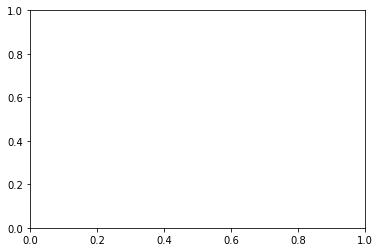

In [ ]:
draw_graph(10, 3, loss, train_acc, val_acc)

In [ ]:
'''
def draw_graph(loss, train_acc, val_acc):
  #num_times = np.array(range(1,times+1))
  #num_epoch = np.array(range(1,times*epoch+1))
  plt.plot(loss)
  #plt.plot(num_epoch, loss)
  plt.title("training loss vs epochs")
  plt.show()

  plt.plot(train_acc, label="training")
  plt.plot(val_acc, label="validation")

  #plt.plot(num_times, train_acc, label="training")
  #plt.plot(num_times, val_acc, label="validation")
  plt.title("accuracy vs training times")
  plt.show()
'''

In [ ]:
loss, train_acc, val_acc = train_and_test(1, 1)

In [ ]:
train_and_test(1, 2)